In [1]:
import json
import glob
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


ts_list = []
accx_list = []
accy_list = []
accz_list = []

for name in glob.glob('./ts_data/*'):
    print(name)
    f = open(name)
    lines = f.readlines()

    for line in lines:
        line_json = json.loads(line)
        # print(line_json['timeStamp'])
        ts = line_json['timeStamp']
        accx = line_json['accx']
        accy = line_json['accy']
        accz = line_json['accz']
        # datetimeObj = datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S.%fZ')
        # print(datetimeObj)
        # print(line_json['accx'])
        ts_list.append(ts)
        accx_list.append(accx)
        accy_list.append(accy)
        accz_list.append(accz)

    # data = json.load(f)
    # data = f
    # print(type(lines[0]))
    print(lines[0])

    f.close()

# construct pandas data frame
ts_pd = pd.to_datetime(pd.Series(ts_list), format='%Y-%m-%dT%H:%M:%S.%fZ')
accx_pd = pd.Series(accx_list)
accy_pd = pd.Series(accy_list)
accz_pd = pd.Series(accz_list)

data_df = pd.DataFrame({'time':ts_pd,'accx':accx_pd,'accy':accy_pd,'accz':accz_pd})
data_df = data_df.astype({'accx':'float'})
data_df = data_df.astype({'accy':'float'})
data_df = data_df.astype({'accz':'float'})



./ts_data/AndroidSensorToS3-3-2020-07-27-13-25-37-bf055b5c-c02b-4868-a677-99329105c141.json
{"timeStamp":"2020-07-27T21:25:35.673Z","magz":"0","accz":"0.173","magy":"0","accy":"9.994","magx":"0","gyrx":"0","gyry":"0","gyrz":"0","accx":"0.788","ts":"2020-07-27T21:25:35.673+0800"}

./ts_data/AndroidSensorToS3-3-2020-07-27-13-10-35-f71fd61b-d651-4ffa-92fd-619b577eabea.json
{"timeStamp":"2020-07-27T21:10:34.468Z","magz":"0","accz":"0.141","magy":"0","accy":"9.987","magx":"0","gyrx":"0","gyry":"0","gyrz":"0","accx":"0.68","ts":"2020-07-27T21:10:34.468+0800"}

./ts_data/AndroidSensorToS3-3-2020-07-27-13-40-39-381a8098-e9fc-45e0-9d70-e4ad429dc147.json
{"timeStamp":"2020-07-27T21:40:37.546Z","magz":"0","accz":"0.189","magy":"0","accy":"9.994","magx":"0","gyrx":"0","gyry":"0","gyrz":"0","accx":"0.812","ts":"2020-07-27T21:40:37.546+0800"}



In [2]:
data_df.columns

Index(['time', 'accx', 'accy', 'accz'], dtype='object')

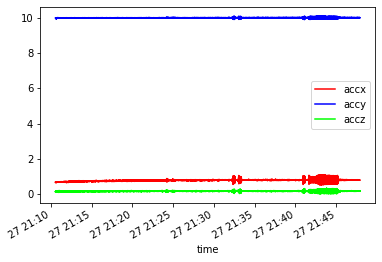

In [3]:
color_dict = {'accx': '#FF0000', 'accy': '#0000FF', 'accz': '#00FF00'}
show_list = ['accx','accy','accz']
data_df.plot('time',show_list,kind='line',color=[color_dict.get(x, '#333333') for x in show_list])

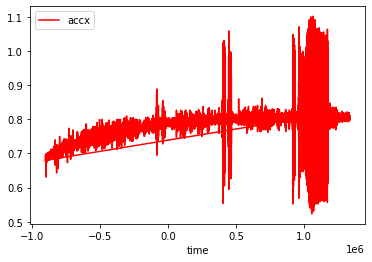

In [91]:
show_list = ['accx']
data_df.plot('time',show_list,kind='line',color=[color_dict.get(x, '#333333') for x in show_list])

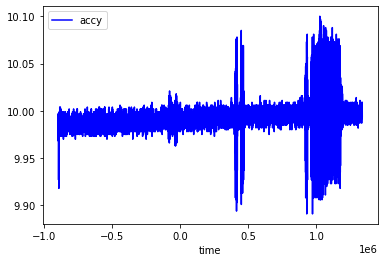

In [92]:
show_list = ['accy']
data_df.plot('time',show_list,kind='line',color=[color_dict.get(x, '#333333') for x in show_list])

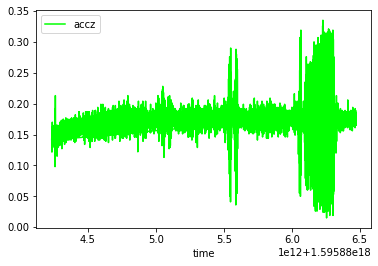

In [76]:
show_list = ['accz']
data_df.plot('time',show_list,kind='line',color=[color_dict.get(x, '#333333') for x in show_list])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import time

# 计算X矩阵的距离矩阵
def compute_squared_EDM(X):
    return squareform(pdist(X, metric='euclidean'))
# data 的第一列是unix时间戳，剩余列是空间坐标数据
# eps1 空间邻域
# eps2 时间邻域
# minPts 满足双邻域的最少点的个数
def ST_DBSCAN(data,eps1,eps2,minPts):
    # 获得数据的行和列(一共有n条数据)
    n, m = data.shape
    # 计算时间距离矩阵
    timeDisMat=compute_squared_EDM(data[:,0].reshape(n, 1))
    # 获得空间距离矩阵
    disMat = compute_squared_EDM(data[:,1:])
    # 将矩阵的中小于minPts的数赋予1，大于minPts的数赋予零，然后1代表对每一行求和,然后求核心点坐标的索引
    # 注意：np.where()的两种用法（搜索、替换功能）
    core_points_index = np.where(np.sum(np.where((disMat <= eps1) &(timeDisMat<=eps2), 1, 0), axis=1) >= minPts)[0]
    # 初始化类别，-1代表未分类。
    print(core_points_index)
    labels = np.full((n,), -1)
    clusterId = 0
    # 遍历所有的核心点
    for pointId in core_points_index:
        # 如果核心点未被分类，将其作为的种子点，开始寻找相应簇集
        if (labels[pointId] == -1):
            # 将点pointId标记为当前类别(即标识为已操作)
            labels[pointId] = clusterId
            # 寻找种子点的eps邻域且没有被分类的点，将其放入种子集合
            neighbour=np.where((disMat[:, pointId] <= eps1) & (timeDisMat[:, pointId] <= eps2) & (labels==-1))[0]
            seeds = set(neighbour)
            # 通过种子点，开始生长，寻找密度可达的数据点，一直到种子集合为空，一个簇集寻找完毕
            print("seed length {}".format(len(seeds)))
            while len(seeds) > 0:
                # 弹出一个新种子点
                newPoint = seeds.pop()
                # 将newPoint标记为当前类
                labels[newPoint] = clusterId
                # 寻找newPoint种子点eps邻域（包含自己）
                queryResults = set(np.where((disMat[:,newPoint]<=eps1) & (timeDisMat[:, newPoint] <= eps2) )[0])
                # 如果newPoint属于核心点，那么newPoint是可以扩展的，即密度是可以通过newPoint继续密度可达的
                if len(queryResults) >= minPts:
                    # 将邻域内且没有被分类的点压入种子集合
                    for resultPoint in queryResults:
                        if labels[resultPoint] == -1:
                            seeds.add(resultPoint)
            # 簇集生长完毕，寻找到一个类别
            clusterId = clusterId + 1
    return labels
def plotFeature(data, labels_):
    clusterNum=len(set(labels_))
    fig = plt.figure()
    scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange','#BC8F8F','#8B4513','brown']
    ax = fig.add_subplot(111)
    for i in range(-1,clusterNum):
        print(i)
        colorSytle = scatterColors[i % len(scatterColors)]
        subCluster = data[np.where(labels_==i)]
        ax.scatter(subCluster[:,0], subCluster[:,1], c=colorSytle, s=20)
    plt.show()
# data = np.loadtxt("data/cluster_unix_time.csv", delimiter=",")
# start = time.clock()
# labels=ST_DBSCAN(data,3,500,30)
# end = time.clock()
# print('finish all in %s' % str(end - start))
# plotFeature(data[:,1:], labels)

finish all in 0.006787999999999794
-1
0
1
2
3


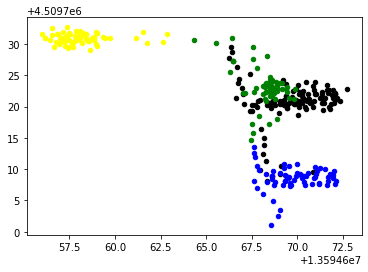

In [4]:
import numpy.linalg as LA
# 将样本X从簇i移动到簇j时产生的增量的变化
# 如果增量为负，说明将i移动到簇j是有益的
# x是样本X的索引
# i是第i个簇集的索引
# j是第j个簇集的索引
# data是序列集合
# ns是簇集的个数集合,ns[i]代表第i个簇集具有多少元素
# us是簇集的平均点坐标的集合,us[i]代表第i个簇集中心坐标是多少
def computeJ(data,ns,us,x,i,j):
    # 计算增量deltaJ的变化情况
    return (ns[j] / (ns[j] + 1)) * (LA.norm(data[x] - us[j], 1) ** 2) - (ns[i] / (ns[i] + 1)) * (
                LA.norm(data[int(i)] - us[i], 1) ** 2)
# 将样本X从簇i移动到簇j时,假设SOE增量为负，ns，us，J的变化
# ns是簇集的个数集合,ns[i]代表第i个簇集具有多少元素
# us是簇集的平均点坐标的集合,us[i]代表第i个簇集中心坐标是多少
# J 是现有的J
# x是样本X的索引
# i是第i个簇集的索引
# j是第j个簇集的索引
def updateUNJ(data,us,ns,J,deltaJ,x,i,j):
    # 第i个簇集的均值变化
    us[i] = us[i] - (data[x] - us[i]) / (ns[i] - 1)
    # 第j个簇集的均值变化
    us[j] = us[j] + (data[x] - us[j]) / (ns[j] + 1)
    # 第i个簇集的个数减1
    ns[i] = ns[i] - 1
    # 第j个簇集的个数加1
    ns[j] = ns[j] + 1
    J=J+deltaJ
    return us,ns,J
# 初始化类别
# data是数据集
# k是初始化为k个类别
def TS(data,k,n):
    # 初始化边界对象
    bs=np.zeros((k,),dtype=np.int)
    # ls 是一个累加，第i个数被前i-1个数作用
    ls=np.zeros((n,))
    # 初始化labels
    labels=np.zeros((n,),dtype=np.int)
    # 迭代计算ls
    for i in range(1,n):
        ls[i]=ls[i-1]+LA.norm(data[i]-data[i-1],1)
    r=ls[n-1]/k
    i=0
    # 迭代计算边界对象
    for j in range(1,k+1):
        while(r*(j-1)>ls[i]):
            i=i+1
        bs[j-1]=i
    # 计算每一个点的label
    for j in range(k-1):
       labels[bs[j]:bs[j+1]]=j
    labels[bs[k-1]:] = k-1
    return bs,labels
# WKM算法的主函数，
# data是按顺序排列的数据集
# k：指定具有多少个类别
# rho：此参数一般指定为0，用于控制迭代的数量，0:迭代全部，1:只迭代两端
def WKM(data,k,rho):
    # 获得数据具有多少行和多少列
    n,m = data.shape
    # 初始化边界对象，和相应的labels
    bs,labels= TS(data,k,n)
    # 初始化每个类别的us和ns
    us = np.zeros((k, 2))
    ns = np.zeros((k,))
    for j in range(0,k-1):
        ns[j]=bs[j+1]-bs[j]
        us[j]=np.average(data[bs[j]:bs[j+1],:],axis=0)
    ns[k-1]=n-bs[k-1]
    us[k-1] = np.average(data[bs[k-1]:n, :], axis=0)
    # 计算误差
    error=np.sum(np.sqrt(np.sum(np.power(data-us[labels], 2), axis=1)))
    # 迭代聚类，WKM算法
    for j in range(k):
        # 如果当前类别不是第0类
        if j>0:
            # 获得该类的的起始索引
            first=bs[j]
            # 获得该类别的终止索引（这个循环只迭代一半）
            last=first+ int(ns[j]/2*(1-rho))
            # 开始迭代，从x开始迭代
            x=first
            while(x<=last):
                # 计算deltaJ
                deltaJ=computeJ(data,ns,us,x,j,j-1)
                # 如果类别个数小于1，或者deltaJ>0
                # 跳出循环
                if((ns[j]<=1) or deltaJ>=0):
                    break
                # 更新边界索引集合
                bs[j] = bs[j] + 1
                # 更新us, ns, error
                us, ns, error = updateUNJ(data,us, ns, error, deltaJ, x, j, j - 1)
                x = x + 1
        if j<k-1:
            # 获得该类的的终止索引
            last = bs[j+1]-1
            # 获得该类别的起始索引（这个循环只迭代一半）
            first = last-int(ns[j]/2*(1-rho))
            # 开始迭代，从x开始迭代
            x = last
            while (x >= first):
                # 计算deltaJ
                deltaJ = computeJ(data,ns,us,x,j,j+1)
                # 如果类别个数小于1，或者deltaJ>0
                # 跳出循环
                if ((ns[j] <= 1) or deltaJ >= 0):
                    break
                # 更新边界索引集合
                bs[j+1] = bs[j+1] - 1
                # 更新us, ns, error
                us, ns, error = updateUNJ(data,us, ns, error, deltaJ, x, j, j + 1)
                x=x-1
    return bs
# 通过边界对象提取聚类类别
def extract_clustering(bs,n):
    labels = np.zeros((n,), dtype=np.int)
    # 获取一共有多少类别
    k=len(bs)
    # 循环给labels复制，赋予每一个类别
    for j in range(k - 1):
        labels[bs[j]:bs[j + 1]] = j
    labels[bs[k - 1]:] = k - 1
    return labels
data = np.loadtxt("data/cluster.csv", delimiter=",")
start = time.clock()
bs= WKM(data,4,0)
end = time.clock()
print('finish all in %s' % str(end - start))
labels=extract_clustering(bs,data.shape[0])
plotFeature(data,labels)

In [5]:
data_df['time'] = data_df['time'].astype('int')

In [38]:
data_df.head()

time   accx   accy   accz
0  1595885135673000000  0.788  9.994  0.173
1  1595885135832000000  0.795  9.985  0.182
2  1595885135994000000  0.791  9.992  0.165
3  1595885136154000000  0.795  9.990  0.177
4  1595885136311000000  0.786  9.987  0.177

In [6]:
norm_data_df = (data_df-data_df.mean())/(data_df.max()-data_df.min())

In [7]:
norm_data_df = norm_data_df.sort_values(by=['time'])
norm_data_df.head()

time      accx      accy      accz
5659 -0.500109 -0.173448 -0.028355 -0.097113
5660 -0.500039 -0.147541 -0.052278 -0.109613
5661 -0.499969 -0.152723 -0.014001 -0.118988
5662 -0.499898 -0.164813 -0.085771 -0.087738
5663 -0.499828 -0.176902 -0.095340 -0.118988

In [8]:
slim_df = norm_data_df.drop(['accy','accx'],axis=1)

In [9]:
data = slim_df.to_numpy()

In [65]:
disMat = compute_squared_EDM(data[:,1:])

In [23]:
disMat

array([[0.        , 0.01552417, 0.01389244, ..., 0.13630847, 0.12728315,
        0.12903488],
       [0.01552417, 0.        , 0.00424264, ..., 0.12301626, 0.11350771,
        0.11624543],
       [0.01389244, 0.00424264, 0.        , ..., 0.12681088, 0.11717508,
        0.12015407],
       ...,
       [0.13630847, 0.12301626, 0.12681088, ..., 0.        , 0.01220656,
        0.01029563],
       [0.12728315, 0.11350771, 0.11717508, ..., 0.01220656, 0.        ,
        0.01513275],
       [0.12903488, 0.11624543, 0.12015407, ..., 0.01029563, 0.01513275,
        0.        ]])

In [73]:
disMat[:,0]

array([0.        , 0.02876472, 0.03013399, ..., 0.25152259, 0.22854597,
       0.24491273])

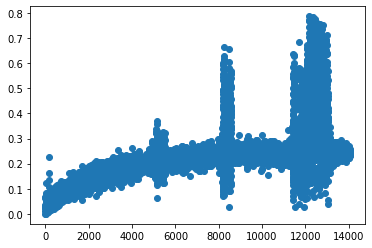

In [72]:
plt.scatter(range(1,14044),disMat[:,0])

In [46]:
n, m = data.shape
timeDisMat=compute_squared_EDM(data[:,0].reshape(n, 1))

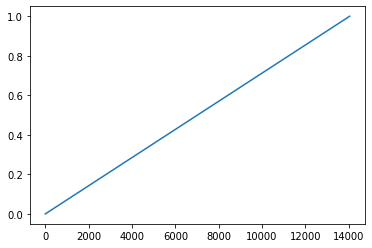

In [74]:
plt.plot(timeDisMat[:,0])

In [55]:
timeDisMat

array([[0.00000000e+00, 7.01385107e-05, 1.40723849e-04, ...,
        9.99858383e-01, 9.99929415e-01, 1.00000000e+00],
       [7.01385107e-05, 0.00000000e+00, 7.05853387e-05, ...,
        9.99788244e-01, 9.99859276e-01, 9.99929861e-01],
       [1.40723849e-04, 7.05853387e-05, 0.00000000e+00, ...,
        9.99717659e-01, 9.99788691e-01, 9.99859276e-01],
       ...,
       [9.99858383e-01, 9.99788244e-01, 9.99717659e-01, ...,
        0.00000000e+00, 7.10320524e-05, 1.41617391e-04],
       [9.99929415e-01, 9.99859276e-01, 9.99788691e-01, ...,
        7.10320524e-05, 0.00000000e+00, 7.05853387e-05],
       [1.00000000e+00, 9.99929861e-01, 9.99859276e-01, ...,
        1.41617391e-04, 7.05853387e-05, 0.00000000e+00]])

In [75]:
eps1=0.1
eps2=0.2
minPts=1000

In [76]:
core_points_index = np.where(np.sum(np.where((disMat <= eps1) &(timeDisMat<=eps2), 1, 0), axis=1) >= minPts)[0]

In [77]:
print(core_points_index)

[    0     1     2 ... 14040 14041 14042]


[    0     1     2 ... 14040 14041 14042]
seed length 1180
finish all in 162.55899399999998
-1
0
1


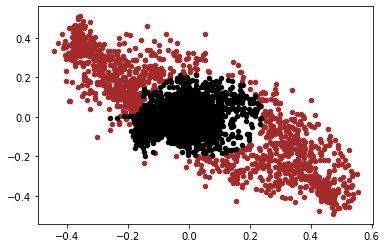

In [78]:
start = time.clock()
labels=ST_DBSCAN(data,eps1,eps2,minPts)
end = time.clock()
print('finish all in %s' % str(end - start))
plotFeature(data[:,1:], labels)

finish all in 0.27013599999999993
-1
0
1


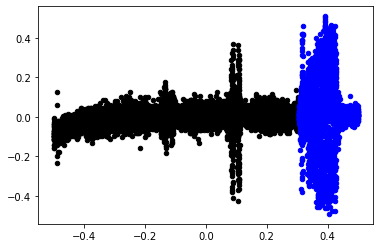

In [11]:
start = time.clock()
bs= WKM(data,2,0)
end = time.clock()
print('finish all in %s' % str(end - start))
labels=extract_clustering(bs,data.shape[0])
plotFeature(data,labels)

-1
0
1


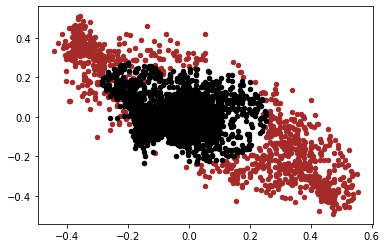

In [63]:
plotFeature(data[:,1:], labels)